### Import Necessary Libraries

In [39]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import faiss
from tqdm import tqdm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

### Data Understanding

In [40]:
DATA_PATH = "tokopedia-product-reviews-2019.csv"

In [41]:
# Load Dataset
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH, index_col=0)
    print(f"Loaded Full Dataset : {DATA_PATH} -> {df.shape}")
else:
    raise FileNotFoundError(
        "No CSV found. Please place a CSV in directory"
    )

Loaded Full Dataset : tokopedia-product-reviews-2019.csv -> (40607, 8)


In [42]:
#Display Basic Info
print("Dataset Overview : ")
print(f"Columns : {df.columns.tolist()}")
print(f"\nFirst 5 Rows : ")
df.head()

Dataset Overview : 
Columns : ['text', 'rating', 'category', 'product_name', 'product_id', 'sold', 'shop_id', 'product_url']

First 5 Rows : 


,text,rating,category,product_name,product_id,sold,shop_id,product_url
1,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...
2,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
3,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
4,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,https://www.tokopedia.com/kamarmesin/alat-stap...
5,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,https://www.tokopedia.com/mitrapersada/isi-ref...


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40607 entries, 1 to 40893
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          40607 non-null  object
 1   rating        40607 non-null  int64 
 2   category      40607 non-null  object
 3   product_name  40607 non-null  object
 4   product_id    40607 non-null  int64 
 5   sold          40593 non-null  object
 6   shop_id       40607 non-null  int64 
 7   product_url   40607 non-null  object
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


### Exploratory Data Analysis

Performing Exploratory Data Analysis...

 Dataset Statistics:
Missing values: 
 text             0
rating           0
category         0
product_name     0
product_id       0
sold            14
shop_id          0
product_url      0
dtype: int64
Duplicate Data :  0


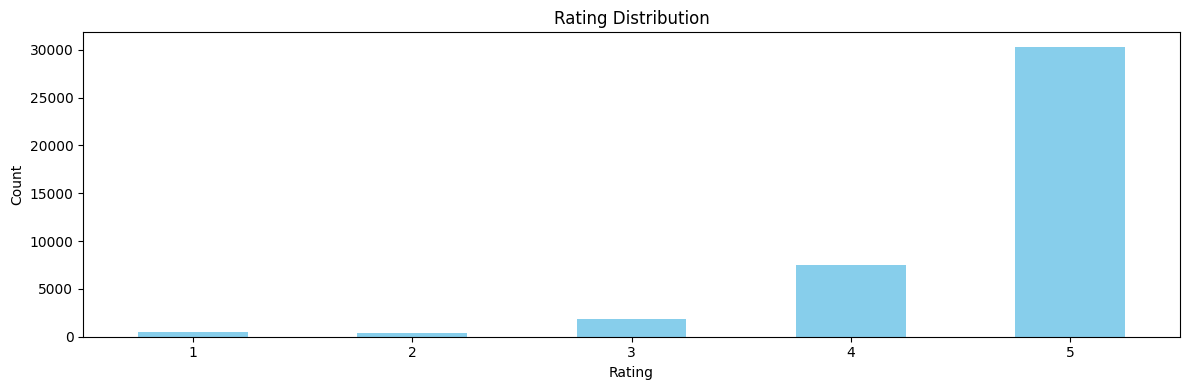

In [44]:
def perform_eda(df):
    """
    Comprehensive exploratory data analysis
    """
    
    print("Performing Exploratory Data Analysis...")
    
    # Basic statistics
    print("\n Dataset Statistics:")
    print("Missing values: \n", df.isna().sum())
    print("Duplicate Data : ", df.duplicated().sum())
    
    # Rating distribution
    if 'rating' in df.columns:
        plt.figure(figsize=(12, 4))
        df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
        plt.title('Rating Distribution')
        plt.xlabel('Rating')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    return df

df_eda = perform_eda(df)

In [45]:
# Check the value of Rating Columns
uniques_counts = df['rating'].value_counts()
print(uniques_counts)

rating
5    30311
4     7546
3     1825
1      543
2      382
Name: count, dtype: int64


### Labelling

In [46]:
# Map Rating -> Sentiment
def map_rating_to_label(label):
    if label >= 4: return "positive"
    if label <= 2: return "negative"
    return "neutral"

df_sentiment = df.dropna(subset=["text", "rating"]).copy()
df_sentiment['label'] = df['rating'].astype(int).map(map_rating_to_label)
df_sentiment[["text","rating","label"]].head()

,text,rating,label
1,Barang sesuai pesanan dan cepat sampai,5,positive
2,Barang bagus harga murah,5,positive
3,Paket rapi...mantap....cepat....sampe ke tujuan,5,positive
4,ya saya puas dgn barangnya,5,positive
5,Responya luar biasa b mantap,5,positive


### Train / Val / Test Split (Stratified)

In [47]:
# Test Set 
X_trainval, X_test = train_test_split(df_sentiment, test_size=0.15, random_state=42, stratify=df_sentiment["label"])

# Split 85% to train & validation
# Validation 15% so 15% of 85% -> 0.176
X_train, X_val = train_test_split(X_trainval, test_size=0.1765, random_state=42, stratify=X_trainval["label"])  # => ~70/15/15 total

for name, X in [("train", X_train), ("val", X_val), ("test", X_test)]:
    print(name, X["label"].value_counts(normalize=True).round(3))

train label
positive    0.932
neutral     0.045
negative    0.023
Name: proportion, dtype: float64
val label
positive    0.932
neutral     0.045
negative    0.023
Name: proportion, dtype: float64
test label
positive    0.932
neutral     0.045
negative    0.023
Name: proportion, dtype: float64


In [48]:
print("FULL:", df_sentiment["label"].value_counts(normalize=True).round(3).to_dict())
print("TRAIN:", X_train["label"].value_counts(normalize=True).round(3).to_dict())
print("VAL  :", X_val["label"].value_counts(normalize=True).round(3).to_dict())
print("TEST :", X_test["label"].value_counts(normalize=True).round(3).to_dict())


FULL: {'positive': 0.932, 'neutral': 0.045, 'negative': 0.023}
TRAIN: {'positive': 0.932, 'neutral': 0.045, 'negative': 0.023}
VAL  : {'positive': 0.932, 'neutral': 0.045, 'negative': 0.023}
TEST : {'positive': 0.932, 'neutral': 0.045, 'negative': 0.023}


The Stratification is worked make the FULL, TRAIN, VAL, TEST at the same class ratios

### Hugging Face

In [49]:
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")  # good for Indonesian

def embed(texts):
    return model.encode(texts, convert_to_numpy=True, normalize_embeddings=True).astype("float32")

E_train = embed(X_train["text"].tolist())
E_val   = embed(X_val["text"].tolist())
E_test  = embed(X_test["text"].tolist())

y_train = X_train["label"].tolist()
y_val   = X_val["label"].tolist()
y_test  = X_test["label"].tolist()

In [50]:
# Logistic Regression Model 
clf = LogisticRegression(max_iter=3000, class_weight="balanced")
clf.fit(E_train, y_train)

print("=== VAL ===")
pred_val = clf.predict(E_val)
print(classification_report(y_val, pred_val, digits=3))

print("=== TEST ===")
pred_test = clf.predict(E_test)
print(classification_report(y_test, pred_test, digits=3))
print("Confusion matrix (TEST):\n", confusion_matrix(y_test, pred_test))

=== VAL ===
              precision    recall  f1-score   support

    negative      0.230     0.705     0.347       139
     neutral      0.092     0.387     0.148       274
    positive      0.978     0.777     0.866      5679

    accuracy                          0.758      6092
   macro avg      0.433     0.623     0.454      6092
weighted avg      0.922     0.758     0.822      6092

=== TEST ===
              precision    recall  f1-score   support

    negative      0.220     0.676     0.332       139
     neutral      0.097     0.401     0.156       274
    positive      0.976     0.779     0.867      5679

    accuracy                          0.760      6092
   macro avg      0.431     0.619     0.452      6092
weighted avg      0.919     0.760     0.822      6092

Confusion matrix (TEST):
 [[  94   35   10]
 [  66  110   98]
 [ 267  988 4424]]


### Downsampling Positives into 3x size of (Negative + Neutral) Combined

In [51]:
# --- Downsample positives in TRAIN only (keep VAL/TEST untouched)
train = X_train.copy()

pos = train[train.label == "positive"]
neu = train[train.label == "neutral"]
neg = train[train.label == "negative"]

# target: make POS about 3x the size of (NEG+NEU) combined
target_pos = int(3 * (len(neu) + len(neg)))

# if we have more positives than target, sample down; else keep all
pos_down = pos.sample(n=min(len(pos), target_pos), random_state=42)

train_bal = pd.concat([pos_down, neu, neg]).sample(frac=1, random_state=42).reset_index(drop=True)

print("TRAIN (original):", X_train.label.value_counts().to_dict())
print("TRAIN (downsampled):", train_bal.label.value_counts().to_dict())


TRAIN (original): {'positive': 26499, 'neutral': 1277, 'negative': 647}
TRAIN (downsampled): {'positive': 5772, 'neutral': 1277, 'negative': 647}


In [52]:
# Rebuild embeddings using the downsampled TRAIN
E_train = embed(train_bal["text"].tolist())
y_train = train_bal["label"].tolist()

# (VAL/TEST stay as you already built)
E_val   = embed(X_val["text"].tolist())
E_test  = embed(X_test["text"].tolist())
y_val   = X_val["label"].tolist()
y_test  = X_test["label"].tolist()


In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

clf = LogisticRegression(max_iter=3000, class_weight="balanced")
clf.fit(E_train, y_train)

print("=== VAL (downsampled-train) ===")
pred_val = clf.predict(E_val)
print(classification_report(y_val, pred_val, digits=3))

print("=== TEST (downsampled-train) ===")
pred_test = clf.predict(E_test)
print(classification_report(y_test, pred_test, digits=3))
print("Confusion matrix (TEST):\n", confusion_matrix(y_test, pred_test))


=== VAL (downsampled-train) ===
              precision    recall  f1-score   support

    negative      0.231     0.727     0.351       139
     neutral      0.089     0.372     0.143       274
    positive      0.979     0.777     0.866      5679

    accuracy                          0.757      6092
   macro avg      0.433     0.625     0.453      6092
weighted avg      0.922     0.757     0.822      6092

=== TEST (downsampled-train) ===
              precision    recall  f1-score   support

    negative      0.223     0.698     0.338       139
     neutral      0.097     0.398     0.156       274
    positive      0.976     0.779     0.867      5679

    accuracy                          0.760      6092
   macro avg      0.432     0.625     0.454      6092
weighted avg      0.919     0.760     0.823      6092

Confusion matrix (TEST):
 [[  97   32   10]
 [  66  109   99]
 [ 272  981 4426]]


### LinearSVC

In [54]:
class_weight = {"negative": 6.0, "neutral": 3.0, "positive": 1.0}

base_svc = LinearSVC(class_weight=class_weight, max_iter=5000)
clf = CalibratedClassifierCV(base_svc, method="sigmoid", cv=3)   # Platt scaling
clf.fit(E_train, y_train)


print("=== VAL (LinearSVC+calibration) ===")
pred_val = clf.predict(E_val)
print(classification_report(y_val, pred_val, digits=3))

print("=== TEST (LinearSVC+calibration) ===")
pred_test = clf.predict(E_test)
print(classification_report(y_test, pred_test, digits=3))
print("Confusion matrix (TEST):\n", confusion_matrix(y_test, pred_test))


=== VAL (LinearSVC+calibration) ===
              precision    recall  f1-score   support

    negative      0.432     0.482     0.456       139
     neutral      0.248     0.197     0.220       274
    positive      0.961     0.968     0.965      5679

    accuracy                          0.922      6092
   macro avg      0.547     0.549     0.547      6092
weighted avg      0.917     0.922     0.920      6092

=== TEST (LinearSVC+calibration) ===
              precision    recall  f1-score   support

    negative      0.417     0.453     0.434       139
     neutral      0.266     0.197     0.226       274
    positive      0.959     0.969     0.964      5679

    accuracy                          0.923      6092
   macro avg      0.547     0.540     0.542      6092
weighted avg      0.916     0.923     0.919      6092

Confusion matrix (TEST):
 [[  63   32   44]
 [  29   54  191]
 [  59  117 5503]]


### Semantic Search (FAISS)

In [55]:
dim = E_train.shape[1]
faiss_index = faiss.IndexFlatIP(dim)   # cosine via normalized embeddings
faiss_index.add(E_train)

def topk_similar(text, k=5):
    v = embed([text])
    D, I = faiss_index.search(v, k)
    rows = X_train.iloc[I[0]][["text","label"]].copy()
    rows["score"] = D[0]
    return rows

# demo
sample = X_test.sample(1).iloc[0]
print("QUERY:", sample["text"])
topk_similar(sample["text"], k=5)

QUERY: Cepet banget baru 1 hari uda aku terima. makasih ya.


,text,label,score
18600,"Pengiriman cepat. \nSaat dicoba, barang berfun...",positive,0.863556
29722,Thank you. Good product.,positive,0.829050
9851,Produk ok..... .. ...........,positive,0.827824
7355,Trimkah brang sudah sampai,positive,0.822676
12723,"Pesanan sdh sampai, terimakasih",positive,0.815312


In [56]:
def predict_with_neighbors(text, k=5):
    v = embed([text])
    label = clf.predict(v)[0]
    D, I = faiss_index.search(v, k)
    nbrs = X_train.iloc[I[0]][["text","label"]].copy()
    nbrs["score"] = D[0]
    return label, nbrs

lab, nbrs = predict_with_neighbors("Barang sesuai deskripsi, kualitas bagus dan pengiriman cepat.", 3)
print("Predicted:", lab); display(nbrs)


Predicted: positive


,text,label,score
34976,barang sudah di terima dengan baik,positive,0.945536
11880,Bagus.... Awalnya kekecilan krn saya pesan ber...,positive,0.899698
19185,"Barang sudah sampai, bekerja dengan baik.",positive,0.899395
